In [1]:
%load_ext autoreload
%matplotlib inline

In [295]:
import os,sys,glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle 

from scipy.ndimage.filters import gaussian_filter,convolve
# interactive
from mpl_toolkits.axes_grid1 import make_axes_locatable
# animation
from matplotlib import animation


In [11]:
## Add own library to path
workdir = os.getcwd()
repodir = workdir
projectname = 'aggregation-time-scale'
while os.path.basename(repodir) != projectname:
    repodir = os.path.dirname(repodir)
print('repo:',repodir)
thismodule = sys.modules[__name__]
## Own functions
moduledir = os.path.join(repodir,'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

repo: /Users/bfildier/Code/analyses/aggregation-time-scale
Own modules available: ['plot2D', 'conditionalstats', 'moistdryedge']


In [289]:
# local input directory
inputdir = os.path.join(repodir,'input','irene')
figdir = os.path.join(repodir,'figures')
moviedir = os.path.join(repodir,'movies')
resultdir = os.path.join(repodir,'results')

## Load own libraries
from moistdryedge import *
from conditionalstats import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

# Load data

In [308]:
# simname = 'SAM6113_RCE_SST301d1p0r1'
simname = 'SAM6113_RCE_SST303d1p0r1'
# simname = 'SAM6113_RCE_SST305d1p0r1'
print('simname:',simname)

# create output subdirectories
os.makedirs(os.path.join(figdir,simname),exist_ok=True)
os.makedirs(os.path.join(moviedir,simname),exist_ok=True)
os.makedirs(os.path.join(resultdir,simname),exist_ok=True)

# get sim-dependent variables
caseid = '_'.join(simname.split('_')[1:])
print('caseid:',caseid)
simdir = os.path.join(inputdir,simname+'.0')
inputfile2D = "%s_256.2Dcom_1.nc"%caseid
inputfile3D = "%s_256_0000432000.com3D.alltimes.nc"%caseid

simname: SAM6113_RCE_SST303d1p0r1
caseid: RCE_SST303d1p0r1


In [309]:
print('load 2D data')
data2D = xr.open_dataset(os.path.join(simdir,inputfile2D))

load 2D data


In [310]:
print('load 3D data')
data3D = xr.open_dataset(os.path.join(simdir,inputfile3D))

load 3D data


# Calculate stats over time

In [311]:
vars4stats = ['PW','CRH','LHF','SHF','LWNT','LWNS']

## Edge 

### Load edges if existing

In [314]:

file_edge_PW = os.path.join(resultdir,simname,"edge_PW.p")
file_edge_CRH = os.path.join(resultdir,simname,"edge_CRH.p")

if os.path.exists(file_edge_PW):
    edge_PW = pickle.load(open(file_edge_PW,"rb"))
if os.path.exists(file_edge_CRH):
    edge_CRH = pickle.load(open(file_edge_CRH,"rb"))


### Calculate edges

In [313]:
print('Calculate edge and stats for boundary defined based on CRH and PW')

#- Get edge
# PW
edge_PW = EdgeOverTime()
edge_PW.compute(data2D.PW)
# CRH
edge_CRH = EdgeOverTime()
edge_CRH.compute(data2D.CRH)

#- Calculate stats
for varid in vars4stats:
    print(varid,end=', ')
    for edge in edge_PW,edge_CRH:
        
        # mean on edge
        edge.computeStatOnEdge(data2D[varid],varid)
        # std on edge
        edge.computeStatOnEdge(data2D[varid],varid,fname='std')
        # mean of gradient norm on edge
        edge.computeGradNormStatOnEdge(data2D[varid],varid)
        # std of gradient norm on edge
        edge.computeGradNormStatOnEdge(data2D[varid],varid,fname='std')

print()

Calculate edge and stats for boundary defined based on CRH and PW
PW, 

/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [315]:
def showErrorRange(ax,x,y,dy,**kwargs):
    
    ax.fill_between(x,y-dy,y+dy,**kwargs)

In [316]:
print("plot to compare edges defined from CRH and PW: stats on the boundary")

x = data2D.time

for varid in vars4stats:

    # create figure 
    fig,ax0 = plt.subplots(ncols=1,figsize=(6,5))
    
    for refvarid in 'PW','CRH':

        edge = getattr(thismodule,"edge_%s"%refvarid)
        # Get data
        v_mean = getattr(edge,"%s_mean"%varid)
        v_std = getattr(edge,"%s_std"%varid)
        # plot
        showErrorRange(ax0,x,v_mean,v_std,alpha=0.2)
        ax0.plot(x,v_mean,label='%s-edge'%refvarid)

    # labels
    ax0.set_xlabel('Days')
    ax0.set_ylabel('%s (%s)'%(varid,data2D[varid].units))
    ax0.legend()

    # save and close figure
    plt.savefig(os.path.join(figdir,simname,"%s_onPWandCRHedge.pdf"%varid),bbox_inches='tight')
    plt.close()


plot to compare edges defined from CRH and PW: stats on the boundary


In [317]:
print("compute fraction area from thresholds based on PW and CRH")

# dry fraction area defined as PW below its value at the PW-edge
edge_PW.computeFractionArea(data2D.PW,'PW')
# dry fraction area defined as CRH below its value at the CRH-edge
edge_CRH.computeFractionArea(data2D.CRH,'CRH')

compute fraction area from thresholds based on PW and CRH


plot to compare edges defined from CRH and PW: dry fraction area


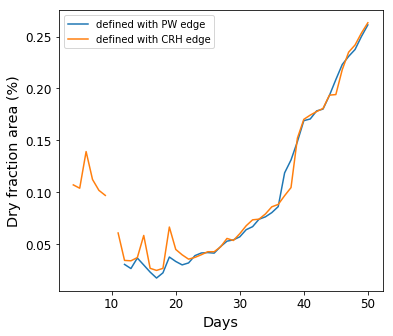

In [318]:
print("plot to compare edges defined from CRH and PW: dry fraction area")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(6,5))

ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('Dry fraction area (%)')
ax0.legend()

# save and close figure
plt.savefig(os.path.join(figdir,simname,"dry_fracarea_fromPWandCRHedge.pdf"),bbox_inches='tight')
plt.show()

In [319]:
print("compute horizontal speed on edge")

UHSFC = np.sqrt(data2D.USFC**2 + data2D.VSFC**2)

edge_CRH.computeStatOnEdge(UHSFC,varid='UHSFC')
edge_PW.computeStatOnEdge(UHSFC,varid='UHSFC')

compute horizontal speed on edge


### Save edges

In [144]:
print("save edges defined from PW and CRH")

pickle.dump(edge_PW,open(os.path.join(resultdir,simname,"edge_PW.p"),"wb"))
pickle.dump(edge_CRH,open(os.path.join(resultdir,simname,"edge_CRH.p"),"wb"))

save edges defined from PW and CRH


## Absolute stats over time

In [320]:
print("compute PW and CRH stats")

r_refs = [10,25,50,75,90]

# PW
dist_PW = DistributionOverTime(name='PW',time_ref=data2D.time)
dist_PW.computeDistributions(data2D.PW)
dist_PW.computeIndividualPercentiles(data2D.PW,r_refs)
# CRH
dist_CRH = DistributionOverTime(name='CRH',time_ref=data2D.time)
dist_CRH.computeDistributions(data2D.CRH)
dist_CRH.computeIndividualPercentiles(data2D.CRH,r_refs)

compute PW and CRH stats


plot to compare aggregation definitions: PW/CRH at boundary and percentiles


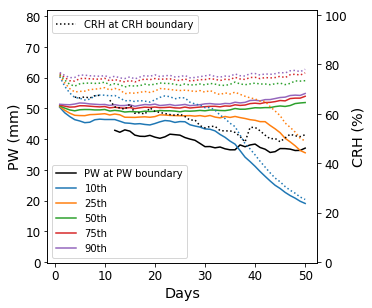

In [321]:
print("plot to compare aggregation definitions: PW/CRH at boundary and percentiles")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(5,4.5))

# ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
# ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

varids = 'PW','CRH'
lt = '-',':'
# col_r = 
ax1 = ax0.twinx()
axs = [ax0,ax1]

for i in range(2):

    v = varids[i]
    edge = getattr(thismodule,"edge_%s"%v)
    dist = getattr(thismodule,"dist_%s"%v)
    
    # plot mean value at boundary
    axs[i].plot(x,getattr(edge,"%s_mean"%v),c='k',label='%s at %s boundary'%(v,v),linestyle=lt[i])
    # plot percentiles
    for i_r in range(len(r_refs)):
        r = r_refs[i_r]
        lab = None
        if i == 0: # turn off labels for CRH percentiles
            lab = '%2.0fth'%r
        axs[i].plot(dist.time,getattr(dist,"perc%2.0f"%r),label=lab,linestyle=lt[i])

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('PW (mm)')
ax1.set_ylabel('CRH (%)')
ax1.set_ylim((-0.2,102))
ax0.set_ylim((-0.2,82))
ax0.legend()
ax1.legend(loc='upper left')

# save and close figure
plt.savefig(os.path.join(figdir,simname,"PW_and_CRH_at_edge_vs_percentile.pdf"),bbox_inches='tight')
plt.show()

plot to compare aggregation definitions: dry fraction area from border and PW/CRH percentiles


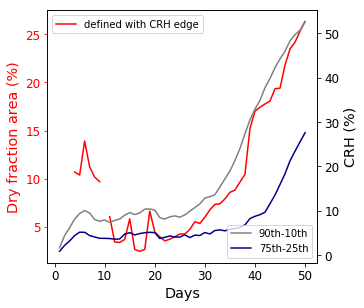

In [322]:
print("plot to compare aggregation definitions: dry fraction area from border and PW/CRH percentiles")

x = data2D.time
fig,ax0 = plt.subplots(ncols=1,figsize=(5,4.5))

# ax0.plot(x,edge_PW.fracarea_PW,label='defined with PW edge')
# ax0.plot(x,edge_CRH.fracarea_CRH,label='defined with CRH edge')

# varids = 'PW','CRH'
# varids = 'PW',
varids = 'CRH',
lt = '-',':'

for i in range(len(varids)):

    v = varids[i]
    edge = getattr(thismodule,"edge_%s"%v)
    dist = getattr(thismodule,"dist_%s"%v)
    
    ax0.plot(x,getattr(edge,"fracarea_%s"%v)*100,c='r',label='defined with %s edge'%v,linestyle=lt[i])
    ax1 = ax0.twinx()
    ax1.plot(dist.time,dist.perc90-dist.perc10,c='Gray',label='90th-10th',linestyle=lt[i])
    ax1.plot(dist.time,dist.perc75-dist.perc25,c='DarkBlue',label='75th-25th',linestyle=lt[i])
    
    ax1.spines['right'].set_position(('data',ax1.get_xlim()[1]+i*10))
    ax1.set_ylabel('%s (%s)'%(v,data2D[v].units))

# labels
ax0.set_xlabel('Days')
ax0.set_ylabel('Dry fraction area (%)')
ax0.tick_params(axis='y', colors='red')
ax0.yaxis.label.set_color('red')
ax0.legend()

ax1.legend(loc='lower right')

# save and close figure
plt.savefig(os.path.join(figdir,simname,"dry_fracarea_edge_vs_percentile_from_%s_edge.pdf"%('_'.join(varids))),bbox_inches='tight')
plt.show()

### Save distributions

In [323]:
print("save PW and CRH ditributions")

pickle.dump(dist_PW,open(os.path.join(resultdir,simname,"dist_PW.p"),"wb"))
pickle.dump(dist_CRH,open(os.path.join(resultdir,simname,"dist_CRH.p"),"wb"))

save PW and CRH ditributions


## Conditional stats

In [324]:
def gaussian_filter_xy(arr,sigma=8):
    """Smooth in x an y and recombine with same shape.
    Assumes dimensions T,Z,Y,X"""
    
    ashape = arr.shape
    
    if len(ashape) == 3:
        Nt,Ny,Nx = ashape
        Nz = 0
    elif len(ashape) == 4:
        Nt,Nz,Ny,Nx = ashape
    
    arr_out = np.nan*np.zeros(ashape)
    
    for i_t in range(Nt):
        
        if Nz == 0:
            arr_out[i_t,:,:] = gaussian_filter(arr[i_t,:,:],sigma=sigma,mode='wrap')
        
        else:
            for i_z in range(Nz):

                arr_out[i_t,i_z,:,:] = gaussian_filter(arr[i_t,i_z,:,:],sigma=sigma,mode='wrap')
            
    return arr_out

In [325]:
print("smooth data before computing conditional statistics")

PW_smooth = gaussian_filter_xy(data2D.PW,8)
CRH_smooth = gaussian_filter_xy(data2D.CRH,8)
W_smooth = gaussian_filter_xy(data3D.W,8)
QRAD_smooth = gaussian_filter_xy(data3D.QRAD,8)

smooth data before computing conditional statistics


In [ ]:
print("compute reference statistics")

width = 10

# PW
dist_PW_smooth = DistributionOverTime(name='PW_smooth',width=width,time_ref=data2D.time)
dist_PW_smooth.computeDistributions(PW_smooth)
dist_PW_smooth.storeSamplePoints(PW_smooth)
dist_PW_smooth.computeIndividualPercentiles(PW_smooth,r_refs)
# CRH
dist_CRH_smooth = DistributionOverTime(name='CRH_smooth',width=width,time_ref=data3D.time)
dist_CRH_smooth.computeDistributions(CRH_smooth)
dist_CRH_smooth.storeSamplePoints(CRH_smooth)
dist_CRH_smooth.computeIndividualPercentiles(CRH_smooth,r_refs)

compute reference statistics
0_11 ; 1_12 ; 2_13 ; 3_14 ; 4_15 ; 5_16 ; 6_17 ; 7_18 ; 8_19 ; 9_20 ; 10_21 ; 11_22 ; 12_23 ; 13_24 ; 14_25 ; 15_26 ; 16_27 ; 17_28 ; 18_29 ; 19_30 ; 20_31 ; 21_32 ; 22_33 ; 23_34 ; 24_35 ; 25_36 ; 26_37 ; 27_38 ; 28_39 ; 29_40 ; 30_41 ; 31_42 ; 32_43 ; 33_44 ; 34_45 ; 35_46 ; 

In [304]:
print("save reference distributions")

pickle.dump(dist_PW_smooth,open(os.path.join(resultdir,simname,"dist_PW_smooth_dt%s.p"%width),"wb"))
pickle.dump(dist_CRH_smooth,open(os.path.join(resultdir,simname,"dist_CRH_smooth_dt%s.p"%width),"wb"))


save reference distributions


In [284]:
print("compute conditional W and QRAD")

refvars = 'PW','CRH'
condvars = 'W',"QRAD"

for refvar in refvars:
    for condvar in condvars:

        # initialize
        refdata = getattr(thismodule,"dist_%s_smooth"%refvar)
        d = ConditionalDistributionOverTime(name=condvar,
                                            time_ref=data2D.time,
                                            width = width,
                                            is3D=True,
                                            isTime=True,
                                            on=refdata)
        
        # compute
        conddata = getattr(thismodule,"%s_smooth"%condvar)
        d.computeConditionalStatsOverTime(conddata)
        
        setattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar),d)

compute conditional W and QRAD


In [305]:
print("save conditional distributions")

refvars = 'PW','CRH'
condvars = 'W',"QRAD"

for refvar in refvars:
    for condvar in condvars:
        
        cdist = getattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar))
        savename = "cdist_%s_on_%s_smooth_dt%s.p"%(condvar,refvar,width)

        pickle.dump(cdist,open(os.path.join(resultdir,simname,savename),"wb"))

save conditional distributions


In [285]:
def computeStreamFunction(cdist):
    
    phi = []
    for i_t in range(len(cdist.cond_distributions)):
        cv = cdist.cond_distributions[i_t].cond_mean
        drv = np.diff(cdist.cond_distributions[i_t].on.bins)[0]
        phi_i = -np.cumsum(cv,axis=1)*drv
        phi.append(phi_i)
        
    return phi

In [306]:
print("compute streamfunctions")

phi_CRH = computeStreamFunction(cdist_W_on_CRH)
phi_PW = computeStreamFunction(cdist_W_on_PW)

compute streamfunctions


In [307]:
print("save streamfunctions")

refvars = 'PW','CRH'

for refvar in refvars:
        
    phi = getattr(thismodule,"phi_%s"%(refvar))
    savename = "phi_on_%s_smooth_dt%s.p"%(refvar,width)
    pickle.dump(cdist,open(os.path.join(resultdir,simname,savename),"wb"))

save streamfunctions


In [301]:
def makeMovie(condvar,refvar,cdist,phi,movie_path,edge=None):

    i_tmin = cdist.dn
    i_tmax = int(data3D.time[-1]) - cdist.dn
    d = cdist.cond_distributions[i_tmin]

    ##- min-max values of conditional mean
    # background
    vmins = [np.nanmin(cdist.cond_distributions[i_t].cond_mean) for i_t in cdist.iterTime()]
    vmaxs = [np.nanmax(cdist.cond_distributions[i_t].cond_mean) for i_t in cdist.iterTime()]
    vmax = max(abs(np.max(vmaxs)),abs(np.min(vmins)))
    vmin = -vmax
    # circulation
    phimax = np.max(np.abs(phi))
    phimin = -phimax
    # x axis
    xmins = [np.nanmin(cdist.cond_distributions[i_t].on.percentiles) for i_t in cdist.iterTime()]
    xmaxs = [np.nanmax(cdist.cond_distributions[i_t].on.percentiles) for i_t in cdist.iterTime()]
    xmax = np.max(xmaxs)
    xmin = np.min(xmins)

#     xmin,xmax = 0,60

    x = d.on.percentiles
    y = data3D.z/1000
    Z = d.cond_mean
    Zphi = phi[0]

    # Initialize
    h = subplotSmooth2D(ax,x,y,Z,\
                       fplot='contourf',\
                       vmin=vmin,vmax=vmax,nlev=200,\
                       xmin=xmin,xmax=xmax,nx=100,\
                       cmap = plt.cm.seismic)

    circ = subplotSmooth2D(ax,x,y,Zphi,\
                            fplot='contour',\
                            vmin=phimin,vmax=phimax,nlev=30,\
                            xmin=xmin,xmax=xmax,nx=100,\
                            cmap = plt.cm.gray_r)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar1 = fig.colorbar(h, cax=cax, orientation='vertical')

    ax.set_xlabel('%s (%s)'%(refvar,data2D[refvar].units))
    ax.set_ylabel('z (km)')
    ax.set_ylim((0,18))

    t = ax.set_title('%s|%s (%s); t = %2.1f days'%(condvar,refvar,data3D[condvar].units.rstrip(),\
                                                   data3D.time[i_tmin]))

    # update function
    def update(i_t):

        ax.cla()

        print(i_t,end=', ')

        d = cdist.cond_distributions[i_t-cdist.dn]
        x = d.on.percentiles
        Z = d.cond_mean
        Zphi = phi[i_t-cdist.dn]
        # edge
        x_edge = None
        if edge is not None:
            x_edge = getattr(edge,'%s_mean'%refvar)[i_t]

        h = subplotSmooth2D(ax,x,y,Z,\
                       fplot='contourf',\
                       vmin=vmin,vmax=vmax,nlev=200,\
                       xmin=xmin,xmax=xmax,nx=100,\
                       cmap = plt.cm.seismic)

        circ = subplotSmooth2D(ax,x,y,Zphi,\
                            fplot='contour',\
                            vmin=phimin,vmax=phimax,nlev=30,\
                            xmin=xmin,xmax=xmax,nx=100,\
                            cmap = plt.cm.gray_r)

        ax.set_title('%s|%s (%s); t = %2.1f days'%(condvar,refvar,data3D[condvar].units.rstrip(),\
                                                 data3D.time[i_t]))

        ax.set_xlabel('%s (%s)'%(refvar,data2D[refvar].units))
        ax.set_ylabel('z (km)')
        ax.set_ylim((0,18))

        # Show edge
        ax.axvline(x=x_edge,c='k',linestyle=':')
        
        return 

    # shift figure to the left for display
    fig.tight_layout(h_pad=0.5)

    anim = animation.FuncAnimation(fig, update,
                                   frames=range(i_tmin,i_tmax), interval=200, blit=False)

    writer = animation.writers['ffmpeg'](fps=3)
    # mywriter = animation.FFMpegWriter(fps=3, extra_args=['-vcodec', 'libx264'])

    anim.save(movie_path,writer=writer)

Make movie
5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 

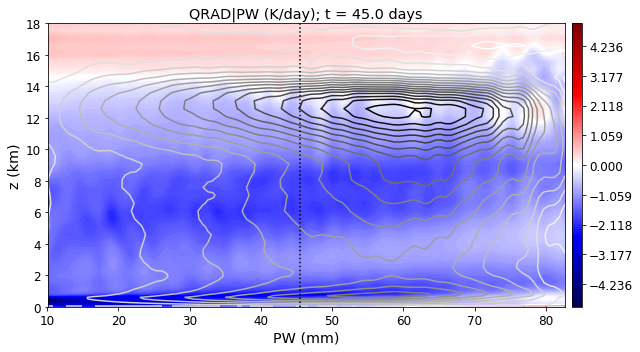

In [303]:
print("Make movie")

fig,ax = plt.subplots(figsize=(9,5))

# condvar = 'W'
condvar = 'QRAD'
# refvar = 'CRH'
refvar = 'PW'

cdist = getattr(thismodule,"cdist_%s_on_%s"%(condvar,refvar))
phi = getattr(thismodule,"phi_%s"%refvar)
edge = getattr(thismodule,"edge_%s"%refvar)
movie_path = os.path.join(moviedir,simname,'%s_on_%s_and_circulation_dt%d.mp4'%(condvar,refvar,width))

makeMovie(condvar,refvar,cdist,phi,movie_path,edge=edge)


## Tests